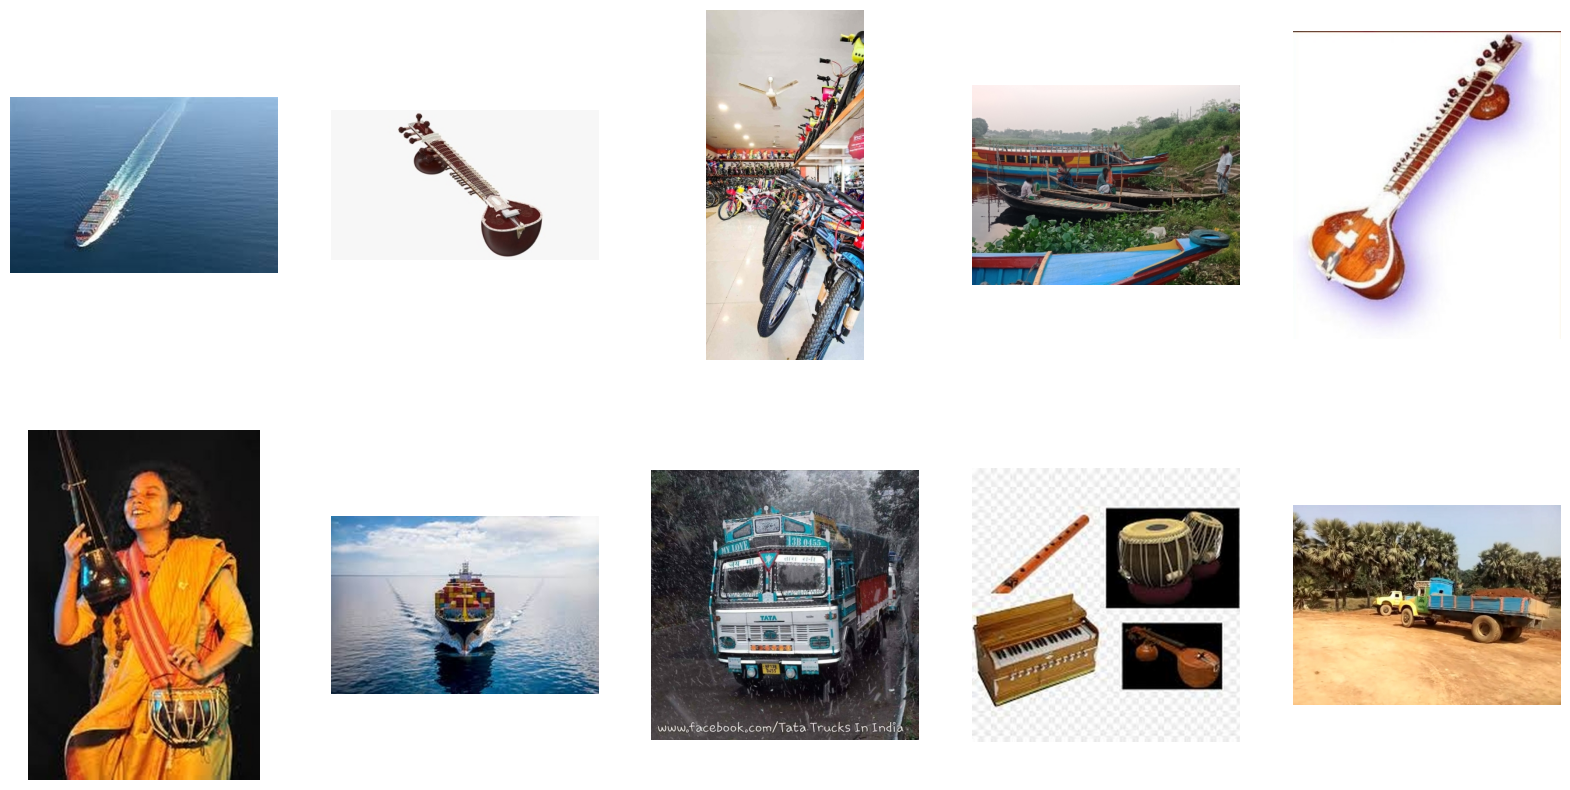

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = '/Users/ganapathynagasubramaniam/Desktop/YabNLP/multilabel_modified/images'

#image set for caption classification

image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

def display_images(image_paths, columns=5, rows=2):
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, min(columns*rows + 1, len(image_paths) + 1)):  # Ensure within bounds
        img_path = os.path.join(image_directory, image_paths[i-1])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        img = Image.open(img_path)
        ax = fig.add_subplot(rows, columns, i)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

display_images(image_files[:10])


In [17]:
import torch 
from torchvision import models, transforms
from PIL import Image
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(* (list(model.children())[:-1]))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(image_directory + "/" +image_files[0])
image_tensor = transform(image).unsqueeze(0)
with torch.no_grad():
    features = model(image_tensor).squeeze().numpy()
    print(features)
#resnet embeddings for image

/Users/ganapathynagasubramaniam/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ganapathynagasubramaniam/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0.3985148  0.05918444 0.16623326 ... 0.00756576 0.5870033  0.45316952]


In [3]:
import cv2
import numpy as np
def extract_video_frames(video_path, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames
#function for splitting video into image frames for embedding 

In [18]:
import torch
import clip
from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_path = os.path.join(image_directory, image_files[0])
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=1, keepdim=True)

print(image_features.shape)
#using CLIP instead for embeddings 

torch.Size([1, 512])


In [19]:
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
raw_image = Image.open(image_path).convert('RGB')
inputs = processor(raw_image, return_tensors="pt").to(device)
with torch.no_grad():
    caption_ids = model.generate(**inputs)
    caption = processor.decode(caption_ids[0], skip_special_tokens=True)
print(f"generated Caption {caption}")
    

generated Caption a large ship sailing in the ocean


In [22]:
from tqdm import tqdm  
caption_set = {}
BATCH_SIZE = 8
image_batches = [image_files[i : i + BATCH_SIZE] for i in range(0, len(image_files), BATCH_SIZE)]
for batch in tqdm(image_batches, desc= "Generating Captions"):
    images = [Image.open(os.path.join(image_directory, img)).convert('RGB') for img in batch]
    inputs = processor(images, return_tensors="pt").to(device)
    with torch.no_grad():
        caption_ids = model.generate(**inputs, num_beams=3, max_length=30)
        captions = [processor.decode(c, skip_special_tokens=True) for c in caption_ids]
    for img, caption in zip(batch, captions):
        caption_set[img] = caption



Generating Captions: 100%|██████████████████| 981/981 [8:05:31<00:00, 29.70s/it]


NameError: name 'json' is not defined

In [23]:
import json
output_file = "caption.json"
with open(output_file, "w") as f:
    json.dump(caption_set, f, indent=4)


    
print(f"Generated {len(caption_set)} captions and saved to {output_file}")

Generated 7843 captions and saved to caption.json


In [24]:
import torch 
import clip 
import json
from PIL import Image
import os
import numpy
device = "cpu"
model , preprocess = clip.load("ViT-B/32", device=device)
with open("caption.json", "r") as f:
    caption_set = json.load(f)

image_embeddings = {}
text_embeddings = {}
for img, caption in tqdm(caption_set.items(), desc= "Generating Image and Caption embeddings"):
    image_path = os.path.join(image_directory, img)
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim = 1, keepdim = True)
    text_tokens = clip.tokenize([caption]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=1, keepdim = True)
    image_embeddings[img] = image_features.cpu().numpy().tolist()
    text_embeddings[img] = text_features.cpu().numpy().tolist()


Generating Image and Caption embeddings: 100%|█| 7843/7843 [13:49<00:00,  9.46it


NameError: name 'iamge_embeddings' is not defined

In [25]:
with open("image_embeddings.json", "w") as f:
    json.dump(image_embeddings, f)
with open("text_embeddings.json", "w") as f:
    json.dump(text_embeddings, f)
print("generated")

generated
